# EAD：ダイヤモンドの価格予測

データがどのようになっているかを確認して、モデルの作成に役立てましょう


# データについて
- **price**: price in US dollars (\\$326- \\$18,823)
- **carat**: weight of the diamond (0.2--5.01)
- **cut**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- **color**: diamond colour, from J (worst) to D (best)
- **clarity**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- **x**: length in mm (0--10.74)
- **y**: width in mm (0--58.9)
- **z**: depth in mm (0--31.8)
- **depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- **table**: width of top of diamond relative to widest point (43--95)

# ライブラリとデータの読み込み

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [3]:
data_dir = "../data/input/"


train = pd.read_csv(data_dir+"train.csv")
test = pd.read_csv(data_dir+"test.csv")

y_train = train["price"]
X_train = train.drop("price",axis=1)

df = pd.concat([X_train, test], axis=0)

# 単変量解析(Univariate analysis)
`info()`や`describe()` を用いることで、それぞれの変数についての簡単な分析結果を得ることができます。

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37758 entries, 0 to 37757
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       37758 non-null  int64  
 1   carat    37758 non-null  float64
 2   cut      37758 non-null  object 
 3   color    37758 non-null  object 
 4   clarity  37758 non-null  object 
 5   depth    37758 non-null  float64
 6   table    37758 non-null  float64
 7   price    37758 non-null  int64  
 8   x        37758 non-null  float64
 9   y        37758 non-null  float64
 10  z        37758 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.2+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16182 entries, 0 to 16181
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       16182 non-null  int64  
 1   carat    16182 non-null  float64
 2   cut      16182 non-null  object 
 3   color    16182 non-null  object 
 4   clarity  16182 non-null  object 
 5   depth    16182 non-null  float64
 6   table    16182 non-null  float64
 7   x        16182 non-null  float64
 8   y        16182 non-null  float64
 9   z        16182 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.2+ MB


まず分かるのは欠損値が一見して無いことです。このまま学習させることも可能ですが、欠損値の代わりに別の値（0など）で既に埋められている可能性もあるので、もう少しデータの詳細を見る必要があります。

また、いくつか`object`型があるので、カテゴリ変数をどのように扱うのかも一つポイントになりそうです。

In [7]:
train.describe()

,id,carat,depth,table,price,x,y,z
count,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000,37758.000000
mean,18878.500000,0.795603,61.742137,57.461534,3907.652550,5.726246,5.730463,3.535447
std,10899.940069,0.472450,1.426757,2.230704,3967.446263,1.119304,1.151771,0.708647
min,0.000000,0.200000,43.000000,49.000000,326.000000,0.000000,0.000000,0.000000
25%,9439.250000,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,18878.500000,0.700000,61.800000,57.000000,2397.500000,5.690000,5.710000,3.520000
75%,28317.750000,1.040000,62.500000,59.000000,5281.750000,6.540000,6.530000,4.030000
max,37757.000000,4.500000,72.200000,95.000000,18823.000000,10.230000,58.900000,31.800000


In [8]:
test.describe()

,id,carat,depth,table,x,y,z
count,16182.000000,16182.000000,16182.000000,16182.000000,16182.000000,16182.000000,16182.000000
mean,45848.500000,0.803393,61.766364,57.447034,5.742616,5.744005,3.546402
std,4671.485363,0.477606,1.446114,2.243337,1.127424,1.119306,0.698734
min,37758.000000,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,41803.250000,0.400000,61.100000,56.000000,4.720000,4.730000,2.910000
50%,45848.500000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,49893.750000,1.050000,62.500000,59.000000,6.540000,6.540000,4.040000
max,53939.000000,5.010000,79.000000,73.000000,10.740000,10.540000,6.980000


## 欠損値について

上をよく見ると `x`,`y`,`z` の値に 0 が出てきます。 length,width,depth に対応するので、0となるのはおかしいでしょう。

In [14]:
print("train xyz zero num:",len(train[(train['x']==0) | (train['y']==0) | (train['z']==0)]))
print("test xyz zero num:",len(test[(test['x']==0) | (test['y']==0) | (test['z']==0)]))


train xyz zero num: 13
test xyz zero num: 7


## 目的変数について
ターゲットとなる price について少し確認しておきましょう

<AxesSubplot:xlabel='price', ylabel='Count'>

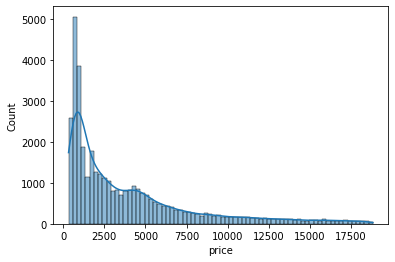

In [33]:
# ヒストグラムと kernel density
sns.histplot(train['price'], kde=True)

<AxesSubplot:xlabel='price', ylabel='Count'>

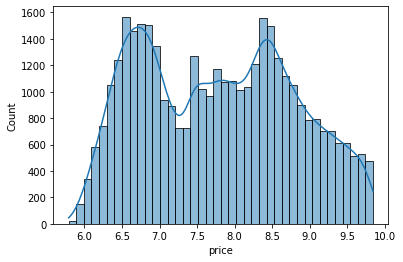

In [4]:
# 対数を取った時
sns.histplot(np.log(train['price'] + 1), kde=True)

# 多変量解析（Multivariate analysis）

## 相関係数

<AxesSubplot:>

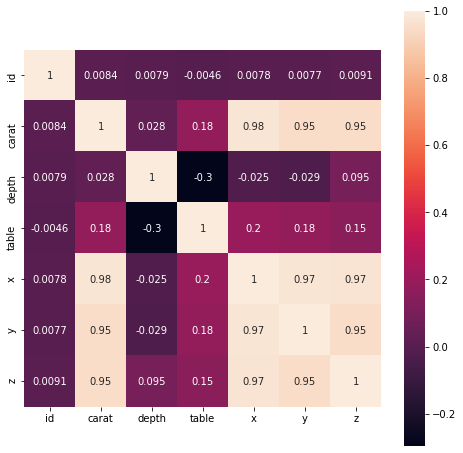

In [24]:
corr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

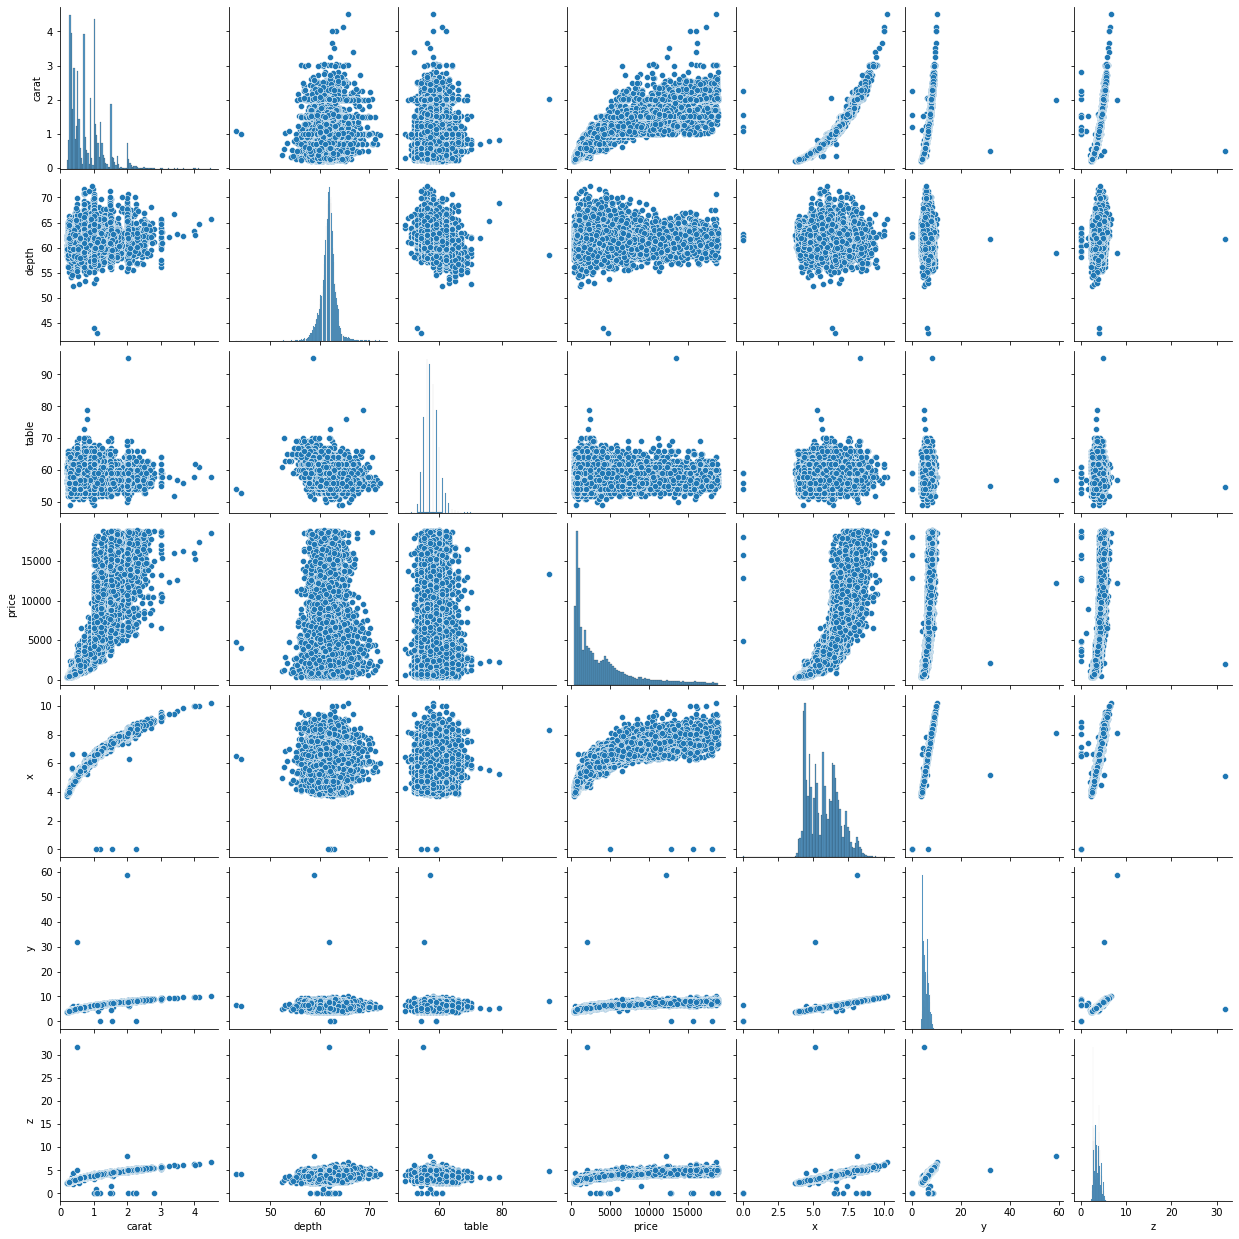

In [16]:
# 少し時間がかかる
sns.pairplot(data=train.drop("id",axis=1))

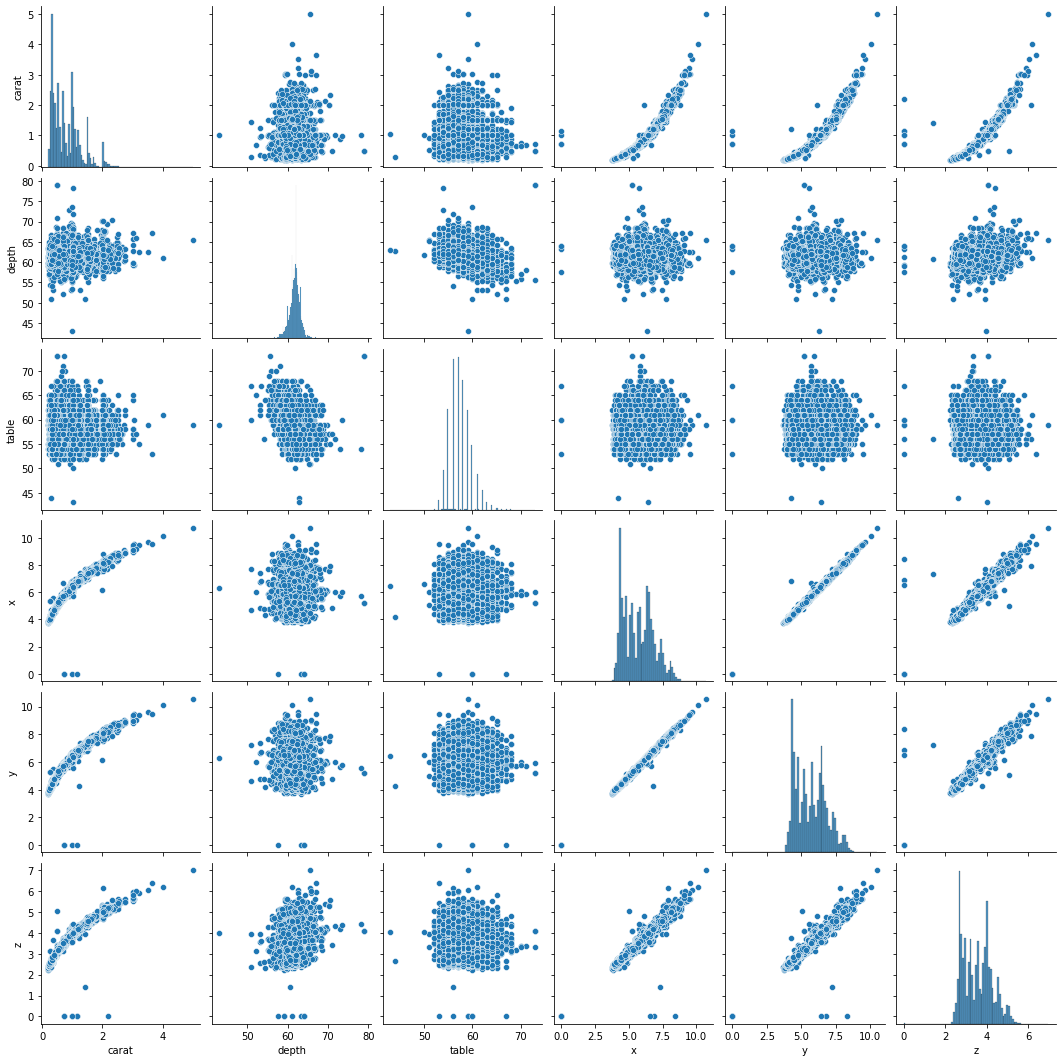

In [17]:
# 少し時間がかかる
sns.pairplot(data=test.drop("id",axis=1))